In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.integrate import solve_ivp
from scipy.stats import sem

from models import *
import stars

from stars.rto.master_vkc import MasterVKC
from stars.rto.reactions import Component, Kinetics

%load_ext autoreload
%autoreload 2

In [2]:
##### SET CONSTANTS FOR ALL SIMULATIONS
TFINAL = 300
TEMP_MAX = 750
T0 = 25.0
O2_init = 0.21
So = 0.1

# Generate Synthetic Data

Use Cinar (2011) reaction model: 
\begin{align*}
1.0 Oil + 4.00 O_2 &\rightarrow 10.00 Coke_1 + 22.389 H_2O  \\
1.0 Coke_1 + 1.50 O_2 &\rightarrow 1.0CO + 1.0 CO_2  \\
1.0 Coke_1 &\rightarrow 2.0 Coke_2 \\
1.0 Coke_2 + 1.4375 O_2 &\rightarrow 0.5 CO + 1.0 CO_2
\end{align*}
from Ogunbanwo (2018).

Run dense sampling of heating rates from 2.0 to 30.0.


In [3]:
# Setup parameters for all runs

TFINAL = 300
TEMP_MAX = 750
T0 = 15.0
O2_init = 0.21
So = 0.1

IC_dict = {'Oil': So, 'O2': O2_init, 'Temp': T0}
exe_path = '"C:\\Program Files (x86)\\CMG\\STARS\\2017.10\\Win_x64\\EXE\\st201710.exe"'

# Build STARS reactions
comp_names = ['Oil', 'Coke1', 'Coke2', 'O2', 'H2O', 'CO', 'CO2']
stars_components = stars.get_component_dict(comp_names)

REAC_COEFFS = np.array([[1.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0, 1.5, 0.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                       [0.0, 0.0, 1.0, 1.4375, 0.0, 0.0, 0.0]])
PROD_COEFFS = np.array([[0.0, 10.0, 0.0, 0.0, 22.389, 0.0, 0.0],
                       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0],
                       [0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0],
                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0]])
REAC_ORDERS = 1.0*np.greater(REAC_COEFFS,0)
PREEXP_FAC = [1e-1, 2.5e3, 2.5e3, 2e-2]
ACT_ENERGY = [2.3e4, 6.7e4, 7.0e4, 9.5e4]
RENTH = [5.97e5, 1e6, 0.0, 4.85e6]

# Assemble STARS reactions list
req_comps = ['Oil', 'O2', 'H2O', 'CO', 'CO2', 'N2'] # required components
comp_names_aug = comp_names + [c for c in req_comps if c not in comp_names]
phases = [stars_components[c].phase for c in comp_names_aug] # get phases
comp_names_srtd = [c for _, c in sorted(zip(phases, comp_names_aug))] # sort comp_names according to phase
comp_names_inds = [comp_names_aug.index(c) for c in comp_names_srtd]

stars_reactions = []
num_pad = len(comp_names_aug) - len(comp_names)
for i in range(4):
    storeac = np.pad(REAC_COEFFS[i,:],(0,num_pad))
    stoprod = np.pad(PROD_COEFFS[i,:],(0,num_pad))
    rorder = np.pad(REAC_ORDERS[i,:],(0,num_pad))

    stars_reactions.append(stars.Kinetics(NAME="RXN"+str(i+1),
                            STOREAC=storeac[comp_names_inds].tolist(),
                            STOPROD=stoprod[comp_names_inds].tolist(),
                            RORDER=rorder[comp_names_inds].tolist(),
                            FREQFAC=PREEXP_FAC[i], 
                            EACT=ACT_ENERGY[i],
                            RENTH=RENTH[i])
                            )
    

In [4]:
# Run linear heating rates

heating_rates = np.arange(2.0, 30.5, 2.0)
exp_dir = 'sensitivity_data'
            
# Run RTO simulations
for hr in heating_rates:
    print('Running heating rate {}...'.format(hr))
    
    TIME = np.arange(0,TFINAL+1)
    TEMP = np.minimum(hr*TIME + T0, TEMP_MAX)
    HEATING_DATA = {'Time':TIME, 'Temp':TEMP}
    
    # Run STARS simulation
    data_folder = os.path.join('datasets','synthetic',exp_dir)
    cd_path = os.path.join(data_folder,str(hr))
    if not os.path.exists(cd_path):
        os.makedirs(cd_path)
    kc = MasterVKC(folder_name = os.path.join(cd_path,''))
    
    write_dict = {
                'COMPS': stars_components, 
                'REACTS': stars_reactions, 
                'IC_dict': IC_dict, 
                'HEATING_DATA': HEATING_DATA,
                'TFINAL': HEATING_DATA['Time'][-1],
                'O2_con_in': IC_dict['O2']
                }
    
    kc.write_dat_file(**write_dict)
    kc.run_dat_file(exe_path, cd_path)
    
    # Save effluence data
    t, ydict = kc.get_reaction_dict()
    df_out = pd.DataFrame()
    df_out['Time'] = t*60
    df_out['Oil'] = ydict['Oil']
    df_out['O2'] = ydict['O2']
    df_out['H2O'] = ydict['H2O']
    df_out['CO'] = ydict['CO']
    df_out['CO2'] = ydict['CO2']
    df_out['N2'] = ydict['N2']
    df_out['Temp'] = ydict['Temp']
    df_out.to_excel(os.path.join(data_folder, str(hr) + '.xls'))
    
    # Print effluence and temperature data to figures
    plt.plot(t, ydict['O2']*100)
    plt.plot(t, ydict['CO']*100)
    plt.plot(t, ydict['CO2']*100)
    plt.plot(t, ydict['N2']*100)
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [% mol]')
    plt.title('Effluence - Heating Rate=' + str(hr))
    plt.legend(['O2', 'CO', 'CO2', 'N2'])
    plt.savefig(os.path.join(cd_path, 'effluence.png'))
    plt.close()
    
    plt.plot(t, ydict['Temp'])
    plt.xlabel('Time [min]')
    plt.ylabel('Temperature [C]')
    plt.title('Temperature - Heating Rate='+str(hr))
    plt.savefig(os.path.join(cd_path, 'temperature.png'))
    plt.close()

Running heating rate 2.0...
Running heating rate 4.0...
Running heating rate 6.0...
Running heating rate 8.0...
Running heating rate 10.0...
Running heating rate 12.0...
Running heating rate 14.0...
Running heating rate 16.0...
Running heating rate 18.0...
Running heating rate 20.0...
Running heating rate 22.0...
Running heating rate 24.0...
Running heating rate 26.0...
Running heating rate 28.0...
Running heating rate 30.0...


Running heating schedule 1...


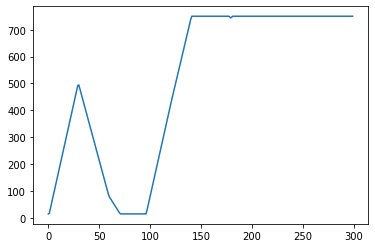

Running heating schedule 2...


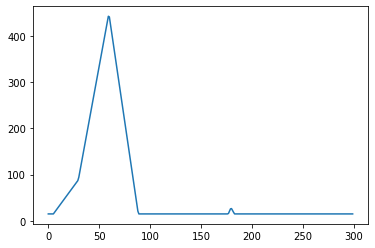

Running heating schedule 3...


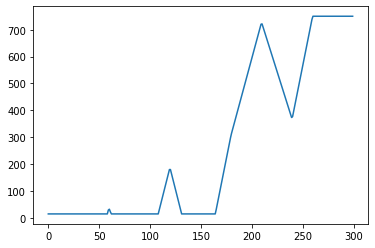

Running heating schedule 4...


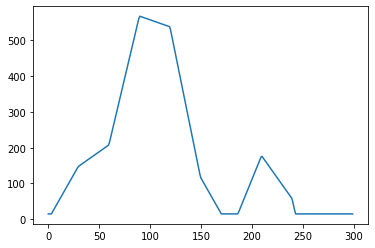

Running heating schedule 5...


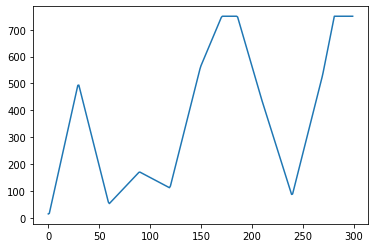

Running heating schedule 6...


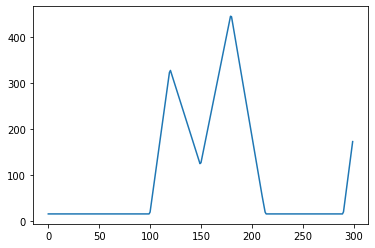

Running heating schedule 7...


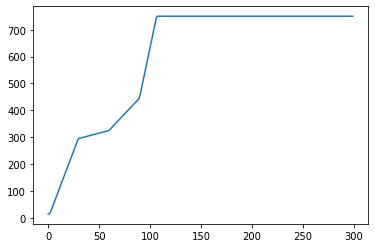

Running heating schedule 8...


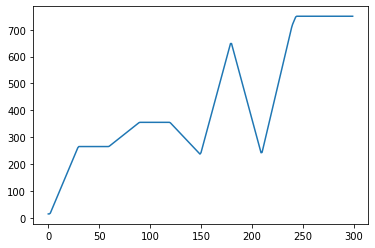

Running heating schedule 9...


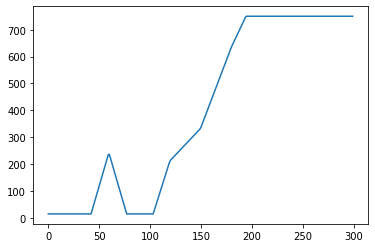

Running heating schedule 10...


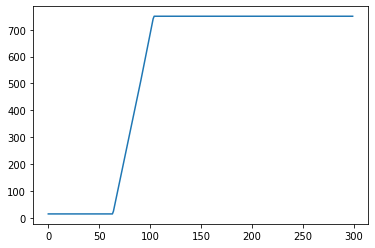

Running heating schedule 11...


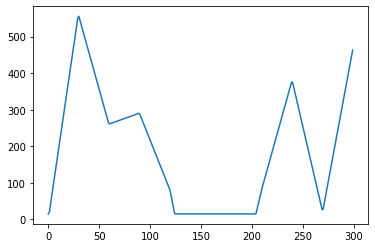

Running heating schedule 12...


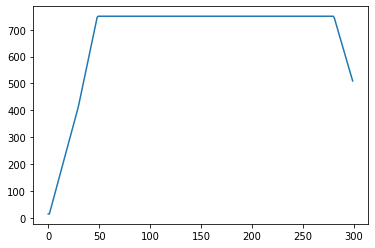

Running heating schedule 13...


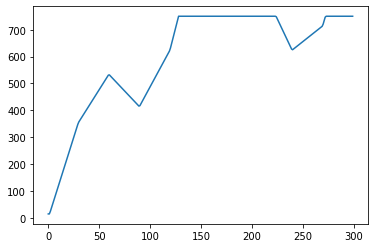

Running heating schedule 14...


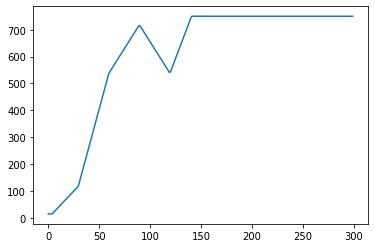

Running heating schedule 15...


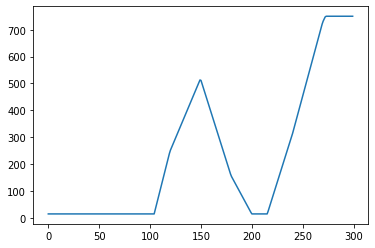

Running heating schedule 16...


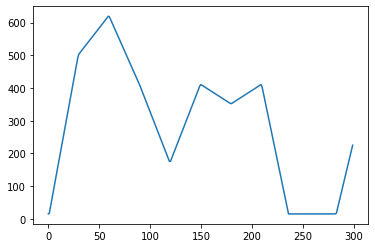

Running heating schedule 17...


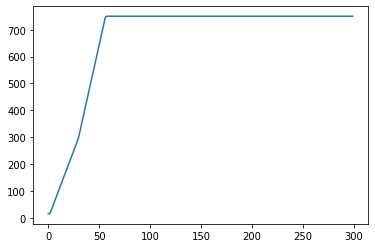

Running heating schedule 18...


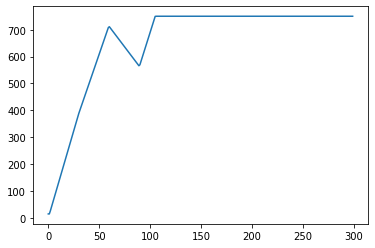

Running heating schedule 19...


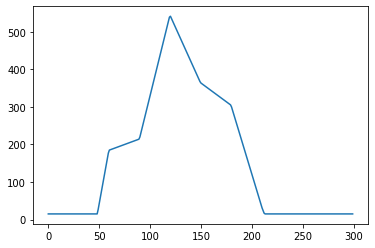

Running heating schedule 20...


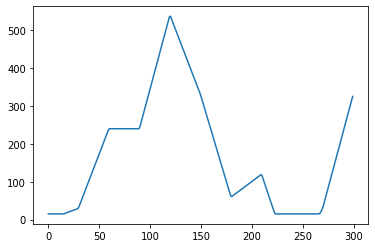

In [14]:
# Run randomized nonlinear heating curves

np.random.seed(0)

exp_dir = 'random_curves'
num_heats = 20
Time = np.arange(0,TFINAL,1)

IC_dict = {'Oil': So, 'O2': O2_init, 'Temp': T0}

# Run STARS simulation
for i in range(num_heats):
    print('Running heating schedule {}...'.format(str(i+1)))
    max_temp_sample = 0
    while max_temp_sample < 400:
        hr_array = np.repeat(np.random.randint(-15, 20, (10)), 30)
        Temp = np.maximum(np.minimum(cumtrapz(hr_array, Time, initial=IC_dict['Temp']), TEMP_MAX), IC_dict['Temp'])
        max_temp_sample = Temp.max()
    plt.plot(Time, Temp)
    plt.show()
    HEATING_DATA = {'Time': Time, 'Temp': Temp}
                               
    # Run STARS simulation
    data_folder = os.path.join('datasets','synthetic', exp_dir)
    cd_path = os.path.join(data_folder,'schedule_'+str(i))
    if not os.path.exists(cd_path):
        os.makedirs(cd_path)
    kc = MasterVKC(folder_name = os.path.join(cd_path,''))
    
    write_dict = {
                'COMPS': stars_components, 
                'REACTS': stars_reactions, 
                'IC_dict': IC_dict, 
                'HEATING_DATA': HEATING_DATA,
                'TFINAL': HEATING_DATA['Time'][-1],
                'O2_con_in': IC_dict['O2']
                }
    
    kc.write_dat_file(**write_dict)
    kc.run_dat_file(exe_path, cd_path)
    
    # Save effluence data
    t, ydict = kc.get_reaction_dict()
    df_out = pd.DataFrame()
    df_out['Time'] = t*60
    df_out['Oil'] = ydict['Oil']
    df_out['O2'] = ydict['O2']
    df_out['H2O'] = ydict['H2O']
    df_out['CO'] = ydict['CO']
    df_out['CO2'] = ydict['CO2']
    df_out['N2'] = ydict['N2']
    df_out['Temp'] = ydict['Temp']
    df_out.to_excel(os.path.join('datasets','synthetic','random_curves', 'schedule_'+str(i+1) + '.xls'))
    
    # Print effluence and temperature data to figures
    plt.plot(t, ydict['O2']*100)
    plt.plot(t, ydict['CO']*100)
    plt.plot(t, ydict['CO2']*100)
    plt.plot(t, ydict['N2']*100)
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [% mol]')
    plt.title('Effluence - Schedule #' + str(i+1))
    plt.legend(['O2', 'CO', 'CO2', 'N2'])
    plt.savefig(os.path.join(cd_path, 'effluence.png'))
    plt.close()
    
    plt.plot(t, ydict['Temp'])
    plt.xlabel('Time [min]')
    plt.ylabel('Temperature [C]')
    plt.title('Temperature -Schedule #'+str(i+1))
    plt.savefig(os.path.join(cd_path, 'temperature.png'))
    plt.close()

C:\Users\timmya\Documents\Research\NAML\models.py:276: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  convplt.show()
C:\Users\timmya\Documents\Research\NAML\models.py:290: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  gradplt.show()


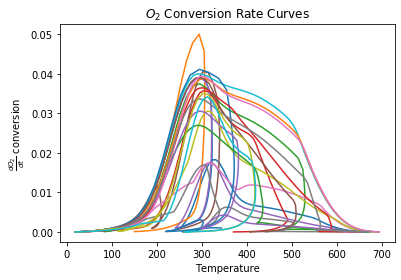

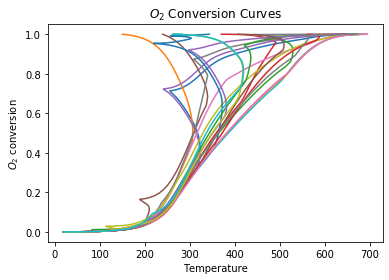

In [18]:
random_container = NonArrheniusInterp(oil_type='synthetic', experiment='random_curves', clean_data=False)
random_container.print_consumption_curves(save_path=os.path.join('results','data_sensitivity','random_curves.png'),
                                            legend=False)

# Analyze Data Sensitivity

Randomly sample heating rates and compute MSE from the sampling. 

In [4]:
# Print the consumption curves
result_dir = os.path.join('results','synthetic_data_plots')
data_container = NonArrheniusML(oil_type='synthetic', experiment='sensitivity_data', clean_data=False)

# data_container.print_surf_plot(save_path = os.path.join(result_dir, 'sensitivity_data_surf.png'))

MemoryError: Unable to allocate array with shape (40000, 1, 6400) and data type float64

In [5]:
# Load data container for random heating data
hr_list = [str(hr) for hr in np.arange(26.0,30.5,2.0).tolist()]
extrap_container = NonArrheniusInterp(oil_type='synthetic', experiment='sensitivity_data', 
                                      clean_data=False, heating_rates=hr_list)
random_container = NonArrheniusInterp(oil_type='synthetic', experiment='random_curves', clean_data=False)

#### Data sensitivity for extrapolation curve data

In [ ]:
# Compute MSEs for extrapolated data

np.random.seed(999)

MAX_NUMBER_EXPERIMENTS = 10
NUMBER_TRIALS = 10

MSE_interp_dict_extrap = {}
MSE_mlc_dict_extrap = {}


for num_heats in range(2,MAX_NUMBER_EXPERIMENTS+1, 2):
    print('Running for {} selected heating rates...'.format(str(num_heats)))
    
    # Simulate and collect MSEs
    MSEs_interp_extrap, MSEs_ml_extrap, MSEs_mlc_extrap = [], [], []
    t = 0
    for t in range(NUMBER_TRIALS):
        print('Running trial {} for extrapolation data...'.format(str(t+1)))
        # Choose heating rates
        selected_hrs = np.random.choice(np.arange(2.0,20.5,2.0),num_heats,replace=False).tolist()
        selected_hrs = [str(hr)+'C_min' for hr in selected_hrs]

        # Build prediction models
        nainterp = NonArrheniusInterp(oil_type='synthetic', experiment='sensitivity_data', 
                                    clean_data=False, heating_rates=selected_hrs)
        naml_const = NonArrheniusML(oil_type='synthetic', experiment='sensitivity_data', 
                                    clean_data=False, heating_rates=selected_hrs, constrained=True)

        # Compute error across all extrapolated heating rates
        MSE_interp, MSE_ml, MSE_mlc = 0, 0, 0
        for i, hr in enumerate(extrap_container.heating_rates):
            # Load data
            Time = extrap_container.Times[i,:]
            Temp = extrap_container.Temps[i,:]
            O2 = extrap_container.O2convs[i,:]

            # Run simulations
            y0=[0.0]
            tspan=[Time[0], Time[-1]]
            heating=[Time, Temp]
            t_interp, y_interp = nainterp.simulate_rto(y0, tspan, heating, max_temp=Temp.max())
            O2_interp = np.interp(Time, t_interp, np.squeeze(y_interp))
            MSE_interp += nainterp.compute_sim_mse({'Time': Time, 'Temp': Temp, 'O2conv': O2},
                                                  {'Time': Time, 'O2conv': O2_interp})
            t_mlc, y_mlc = naml_const.simulate_rto(y0, tspan, heating, max_temp=Temp.max())
            O2_ml = np.interp(Time, t_mlc, np.squeeze(y_mlc))
            MSE_mlc += naml_const.compute_sim_mse({'Time': Time, 'Temp': Temp, 'O2conv': O2},
                                                {'Time': Time, 'O2conv': O2_ml})

        # Log for iteration
        MSEs_interp_extrap.append(MSE_interp)
        MSEs_mlc_extrap.append(MSE_mlc)
    
    # Record trials for MSE in dictionaries
    MSE_interp_dict_extrap[num_heats] = MSEs_interp_extrap
    MSE_mlc_dict_extrap[num_heats] = MSEs_mlc_extrap
    

In [ ]:
print(MSE_interp_dict_extrap)
print(MSE_mlc_dict_extrap)


In [ ]:
# Make error plot for randomized data

exp_nums = [2, 4, 6, 8] # Number of experiments

interp_means = [np.mean(MSE_interp_dict_extrap[i]) for i in exp_nums] 
interp_sems = [sem(MSE_interp_dict_extrap[i]) for i in exp_nums] 
plt.errorbar(exp_nums,interp_means,yerr=interp_sems,label='Interpolation',marker='o', capsize=4)

mlc_means = [np.mean(MSE_mlc_dict_extrap[i]) for i in exp_nums] 
mlc_sems = [sem(MSE_mlc_dict_extrap[i]) for i in exp_nums] 
plt.errorbar(exp_nums,mlc_means,yerr=mlc_sems,label='NAMLA',marker='o', capsize=4)

plt.xlabel('Number of RTO experiments')
plt.ylabel('Total MSE of estimated solutions')
plt.title('Extrapolated Heating Rates Data Plot')
plt.legend(loc='upper right')
plt.savefig(os.path.join('results','data_sensitivity','extrap_error.png'))
plt.show()


#### Data sensitivity for random heating curve data

In [ ]:
# Compute MSEs for random heating rate data

np.random.seed(999)

MAX_NUMBER_EXPERIMENTS = 10
NUMBER_TRIALS = 10

MSE_interp_dict_random = {}
MSE_ml_dict_random = {}
MSE_mlc_dict_random = {}

for num_heats in range(2,MAX_NUMBER_EXPERIMENTS+1, 2):
    print('Running for {} selected heating rates...'.format(str(num_heats)))
    
    # Simulate and collect MSEs
    MSEs_interp_random, MSEs_ml_random, MSEs_mlc_random = [], [], []
    for t in range(NUMBER_TRIALS):
        
        # Choose heating rates
        selected_hrs = np.random.choice(np.arange(2.0,20.5,2.0),num_heats,replace=False).tolist()
        selected_hrs = [str(hr)+'C_min' for hr in selected_hrs]

        # Build prediction models
        nainterp = NonArrheniusInterp(oil_type='synthetic', experiment='sensitivity_data', 
                                    clean_data=False, heating_rates=selected_hrs)
        naml_const = NonArrheniusML(oil_type='synthetic', experiment='sensitivity_data', 
                                    clean_data=False, heating_rates=selected_hrs, constrained=True)

        # Compute error for random heating rates
        print('Running trial {} for random heating curve data...'.format(str(t+1)))
        MSE_interp, MSE_ml, MSE_mlc = 0, 0, 0

        for i, hr in enumerate(random_container.heating_rates):
            # Load data
            Time = random_container.Times[i,:]
            Temp = random_container.Temps[i,:]
            O2 = random_container.O2convs[i,:]

            # Run simulations
            y0=[0.0]
            tspan=[Time[0], Time[-1]]
            heating=[Time, Temp]
            t_interp, y_interp = nainterp.simulate_rto(y0, tspan, heating, max_temp=Temp.max())
            O2_interp = np.interp(Time, t_interp, np.squeeze(y_interp))
            MSE_interp += nainterp.compute_sim_mse({'Time': Time, 'Temp': Temp, 'O2conv': O2},
                                                  {'Time': Time, 'O2conv': O2_interp})
            t_mlc, y_mlc = naml_const.simulate_rto(y0, tspan, heating, max_temp=Temp.max())
            O2_ml = np.interp(Time, t_mlc, np.squeeze(y_mlc))
            MSE_mlc += naml_const.compute_sim_mse({'Time': Time, 'Temp': Temp, 'O2conv': O2},
                                                {'Time': Time, 'O2conv': O2_ml})

        # Log for iteration
        MSEs_interp_random.append(MSE_interp)
        MSEs_mlc_random.append(MSE_mlc)
    
    # Record trials for MSE in dictionaries
    MSE_interp_dict_random[num_heats] = MSEs_interp_random
    MSE_mlc_dict_random[num_heats] = MSEs_mlc_random
    
    

In [ ]:
print(MSE_interp_dict_random)
print(MSE_mlc_dict_random)

In [ ]:
# Make error plot for random data

exp_nums = [2, 4, 6, 8] # Number of experiments

interp_means = [np.mean(MSE_interp_dict_random[i]) for i in exp_nums] 
interp_sems = [sem(MSE_interp_dict_random[i]) for i in exp_nums] 
plt.errorbar(exp_nums,interp_means,yerr=interp_sems,label='Interpolation',marker='o', capsize=4)

mlc_means = [np.mean(MSE_mlc_dict_random[i]) for i in exp_nums] 
mlc_sems = [sem(MSE_mlc_dict_random[i]) for i in exp_nums] 
plt.errorbar(exp_nums,mlc_means,yerr=mlc_sems,label='NAMLA)',marker='o', capsize=4)

plt.xlabel('Number of RTO experiments')
plt.ylabel('Total MSE of estimated solutions')
plt.title('Random Heating Data Error Plot')
plt.legend(loc='upper right')
plt.savefig(os.path.join('results','data_sensitivity','random_error.png'))
plt.show()
